In [100]:
import os
from glob import glob
import re
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from motion_detection_utils import *

# Utilities

In [101]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # blurr image
    frame1 = cv2.GaussianBlur(frame1, dst=None, ksize=(3, 3), sigmaX=5)
    frame2 = cv2.GaussianBlur(frame2, dst=None, ksize=(3, 3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(
        frame1,
        frame2,
        None,
        pyr_scale=0.75,
        levels=3,
        winsize=5,
        iterations=3,
        poly_n=10,
        poly_sigma=1.2,
        flags=0,
    )
    return flow


def get_flow_viz(flow):
    """Obtains BGR image to Visualize the Optical Flow"""
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb


In [102]:
def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    """ Obtains Detection Mask from Optical Flow Magnitude
        Inputs:
            flow_mag (array) Optical Flow magnitude
            motion_thresh - thresold to determine motion
            kernel - kernal for Morphological Operations
        Outputs:
            motion_mask - Binray Motion Mask
        """
    motion_mask = np.uint8(flow_mag > motion_thresh)*255

    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return motion_mask

In [103]:
def visualize(frame1_bgr, frame2_bgr, magnitude):
    img1_rgb = cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB)
    # display
    fig, ax = plt.subplots(1, 3, figsize=(25, 25))
    ax[0].imshow(img1_rgb)
    ax[0].set_title("Frame 1")
    ax[1].imshow(img2_rgb)
    ax[1].set_title("Frame 2")
    ax[2].imshow(
        np.log(magnitude / magnitude.max()), cmap="hsv_r"
    )  # try other cmaps 'hsv_r', 'gist_earth_r', 'rainbow_r', 'twilight_r'
    ax[2].set_title("Log of Dense Optical Flow Magnitude")

    plt.show()

In [104]:
cap = cv.VideoCapture(cv.samples.findFile("SamsungGear360.mp4"))

# skip first 300 frames
# for i in range(2000):
#     ret, frame1 = cap.read()

ret, frame1 = cap.read()

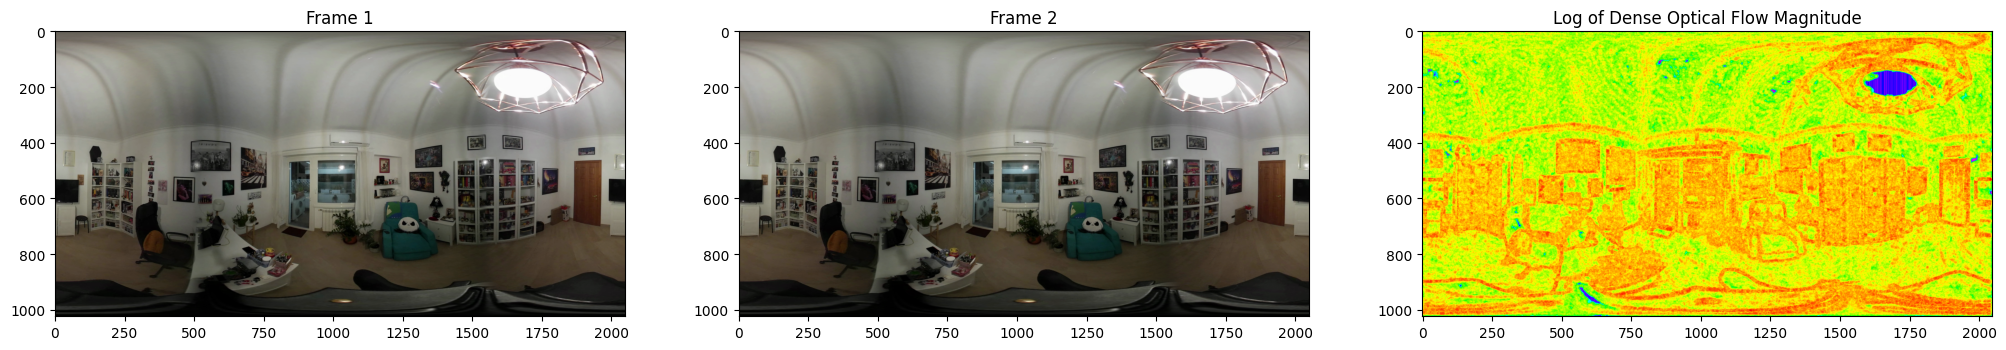

In [105]:

scale = 0.5
frame1_bgr = cv.resize(frame1, (0, 0), fx=scale, fy=scale)

while True:
    ret, frame2 = cap.read()
    if not ret:
        print("No frames grabbed!")
        break

    frame2_bgr = cv.resize(frame2, (0, 0), fx=scale, fy=scale)

    flow = compute_flow(frame1_bgr, frame2_bgr)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

    visualize(frame1_bgr, frame2_bgr, mag)
    break


In [106]:
mag.min(), mag.max()

(7.677709e-18, 23.769077)

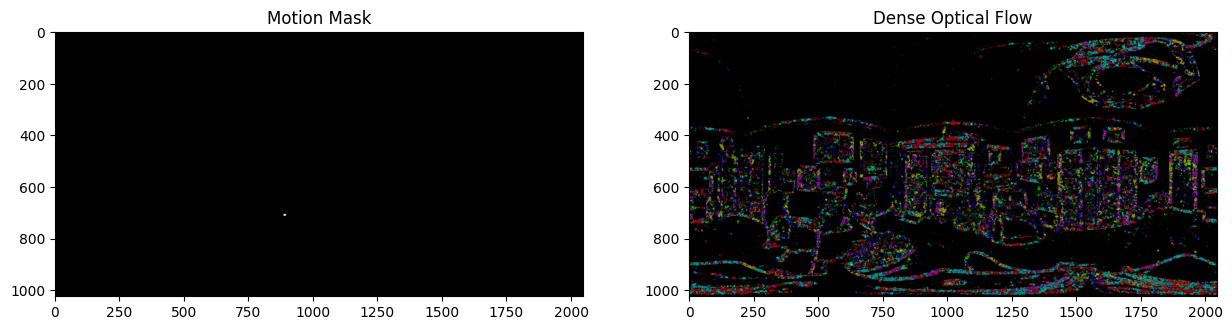

In [107]:
# get optical flow visualization
rgb = get_flow_viz(flow)

# get variable motion thresh based on prior knowledge of camera position
motion_thresh = np.c_[np.linspace(0.3, 1, 1024)].repeat(2048, axis=-1)   # unnormalized threshold

# get motion mask
mask = get_motion_mask(mag, motion_thresh=motion_thresh)  # unnormalized threshold


"""
it's usually a good idea to NORMALIZE! Thanks to https://github.com/ErdosG for pointing this out!
Normalization allows us to be more consistent across data from different domains, this means
it helps us generalize better.
Try uncommenting and running the code below to experiment with normalization
"""
# motion_thresh = np.c_[np.linspace(1e-6, 3e-2, 1080)].repeat(1920, axis=-1)  # normalized threshold
# mask = get_motion_mask(mag/mag.max(), motion_thresh=motion_thresh)          # normalized threshold

# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Motion Mask")
ax[1].imshow(rgb*50) # scale RGB to see the noise
ax[1].set_title("Dense Optical Flow");

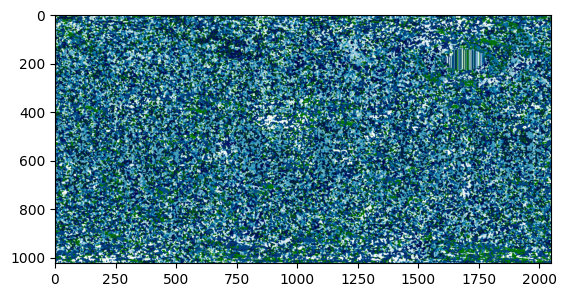

In [108]:
plt.imshow(ang, cmap='ocean') # 'gist_earth_r', 'rainbow_r', 'twilight_r'

 TO DO 

In [109]:
def get_contour_detections_2(mask, ang=ang, angle_thresh=2, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the
        mask. Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            angle_thresh - threshold for flow angle standard deviation
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores 
                        [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    temp_mask = np.zeros_like(mask) # used to get flow angle of contours
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        # get area of contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        # get flow angle inside of contour
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh): # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

In [110]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections_2(mask, ang, angle_thresh=2, thresh=400)
# detections = get_contour_detections(mask, thresh=400)

# separate bboxes and scores
bboxes = detections[:, :4]
scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers");

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

In [ ]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes");

In [ ]:
img2_rgb = cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB)
frame2 = img2_rgb.copy()
draw_bboxes(frame2, nms_bboxes)
plt.imshow(frame2);

In [ ]:
def get_detections(frame1, frame2, motion_thresh=1, bbox_thresh=400, nms_thresh=0.1, mask_kernel=np.ones((7,7), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            motion_thresh - Minimum flow threshold for motion
            bbox_thresh - Minimum threshold area for declaring a bounding box 
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            mask_kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # get optical flow
    flow = compute_flow(frame1, frame2)

    # separate into magntiude and angle
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    motion_mask = get_motion_mask(mag, motion_thresh=motion_thresh, kernel=mask_kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, bbox_thresh)

    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, threshold=nms_thresh)
    

In [ ]:
video_frames = []

# get variable motion thresh based on prior knowledge of camera position
motion_thresh = np.c_[np.linspace(0.3, 1, 1080)].repeat(1920, axis=-1)
kernel = np.ones((7,7), dtype=np.uint8)

while(1):
    # read frames
    ret, frame1 = cap.read()
    ret, frame2 = cap.read()

    frame1_bgr = cv.resize(frame1, (0, 0), fx=scale, fy=scale)
    frame2_bgr = cv.resize(frame2, (0, 0), fx=scale, fy=scale)

    # get detections
    detections = get_detections(frame1_bgr, 
                                frame2_bgr, 
                                motion_thresh=motion_thresh, 
                                bbox_thresh=400, 
                                nms_thresh=0.1, 
                                mask_kernel=kernel)
                                
    # draw bounding boxes on frame
    draw_bboxes(frame2_bgr, detections)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(frame2_bgr)
    plt.axis('off')
    fig.savefig(f"temp/frame_{idx}.png")
    plt.close();

    # OPTIONAL append to list for video
    video_frames.append(frame2_bgr)

In [ ]:
plt.imshow(frame2_bgr)

In [ ]:
create_gif_from_images('optical_flow.gif', 'temp', '.png')